<a href="https://colab.research.google.com/github/Slim205/Acoustic/blob/main/Project_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Control of the numerical solution accuracy of acoustic wave by changing the quality of the mesh


In [ ]:
import matplotlib.pyplot
import matplotlib.pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy
import os
import scipy.io
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import sys
import matplotlib.pyplot as plt

import numpy as np
# MRG packages
import solutions

# Questions 1+2 :


# Quality Criteria for a Quadrangular Mesh



In [ ]:
def compute_aspect_ratio_of_element(node_coords, p_elem2nodes, elem2nodes,elem):
    nodes=elem2nodes[p_elem2nodes[elem]:p_elem2nodes[elem+1]]
    s=0
    for i in range(4):
      s+= np.sqrt(((node_coords[nodes[i]]-node_coords[nodes[(i+1)%4]])**2).sum())
    return 1-s/4


def compute_edge_length_factor_of_element(node_coords, p_elem2nodes, elem2nodes,elem):
    nodes=elem2nodes[p_elem2nodes[elem]:p_elem2nodes[elem+1]]
    l=[]
    for i in range(4) :
      l.append(np.sqrt(((node_coords[nodes[i]]-node_coords[nodes[(i+1)%4]])**2).sum()))
    return min(l)*len(l)/sum(l)


def compute_pointedness_of_element(node_coords, p_elem2nodes, elem2nodes,elem):
    nodes=elem2nodes[p_elem2nodes[elem]:p_elem2nodes[elem+1]]
    elem_coords= compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes)
    bary = elem_coords[elem]
    l=[]
    for i in range(4):
        vect1 = node_coords[nodes[i]] - bary
        vect2 = node_coords[nodes[(i+1)%4]] - bary
        l.append(np.cross(vect1,vect2)[2])

    return min(l)*4/sum(l)

In [ ]:
def run_exercise_a(n):
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)
    # .. todo:: Modify the line below to call to generate a grid with quadrangles
    # p_elem2nodes, elem2nodes, node_coords, node_l2g = my_set_quadmesh(...)
    # .. note:: If you do not succeed, uncomment the following line to access the solution
    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    elem = n
    return compute_aspect_ratio_of_element(node_coords, p_elem2nodes, elem2nodes,elem) , compute_edge_length_factor_of_element(node_coords, p_elem2nodes, elem2nodes,elem)

l = []
p=[]
n= 2
x=[]
for i in range(6) :
    print(n)
    n=2*n
    l.append(run_exercise_a(n)[0])
    p.append(run_exercise_a(n)[1])
    x.append(n*n)
print(run_exercise_a(16), 1-1/16, 1.)



2
4
8
16
32
64
(0.9375, 1.0) 0.9375 1.0


We verify that for a mesh containing an identical square element, the aspect ratio is equal to 1-1/n, and the edge length factor is equal to 1.

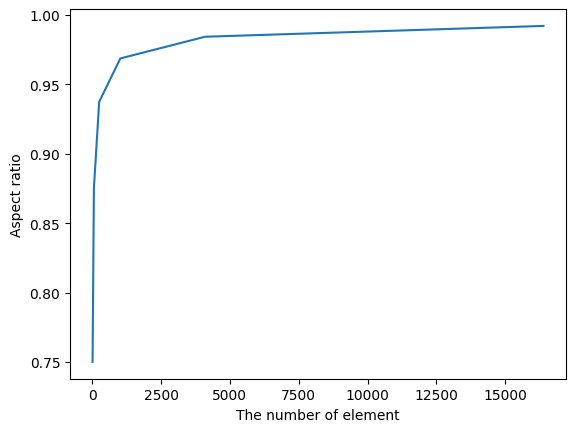

In [ ]:
plt.plot(x,l)
plt.xlabel('The number of element')
plt.ylabel('Aspect ratio')
plt.show()

The edge length factor of one element in our case does not depond of the shape of the mesh. However, the aspect ratio is increasing while the number of element is increasing.

## Quality Criteria for a Triangle Mesh

In [ ]:
def compute_aspect_ratio_of_element_triangle(node_coords, p_elem2nodes, elem2nodes,elem):
    nodes=elem2nodes[p_elem2nodes[elem]:p_elem2nodes[elem+1]]
    l=[]
    for i in range(3):
      l.append(np.sqrt(((node_coords[nodes[i]]-node_coords[nodes[(i+1)%3]])**2).sum()))
    h= max(l)
    alpha = np.sqrt(3)/6
    rau = (sum(l)-2*max(l))/2
    return alpha*h/rau
def compute_edge_length_factor_of_element_triangle(node_coords, p_elem2nodes, elem2nodes,elem):
    nodes=elem2nodes[p_elem2nodes[elem]:p_elem2nodes[elem+1]]
    l=[]
    for i in range(3) :
      l.append(np.sqrt(((node_coords[nodes[i]]-node_coords[nodes[(i+1)%3]])**2).sum()))
    return min(l)*len(l)/sum(l)

1.3938468501173513 1.393846850117352
0.8786796564403572 0.8786796564403575


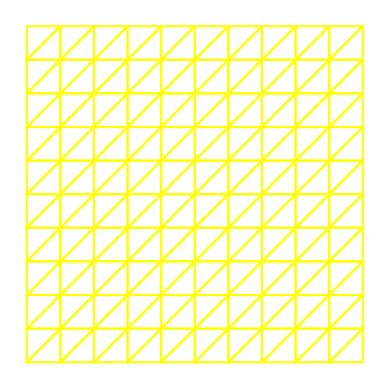

In [ ]:

def run_exercise_b():
    """Generate grid with triangles.
    """
    # -- generate grid with triangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n= 10
    nelemsx, nelemsy = n, n
    nelems = nelemsx * nelemsy * 2
    nnodes = (nelemsx + 1) * (nelemsy + 1)
    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
    nodes_on_boundary = solutions._set_trimesh_boundary(nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')

    elem = n
    print( compute_aspect_ratio_of_element_triangle(node_coords, p_elem2nodes, elem2nodes,elem) , 1/(np.sqrt(6)-np.sqrt(3)))

    print( compute_edge_length_factor_of_element_triangle(node_coords, p_elem2nodes, elem2nodes,elem) , 3/(2+np.sqrt(2)))

run_exercise_b()



For a triangle mesh, it is verified that it does not depend on 'n' and is always equal to alpha times 2 divided by the square root of 2 minus 1. Additionally, the edge length factor is equal to 3 divided by 2 plus the square root of 2.


# Question 3 :

I add an epsilon for the even rows or columns and -epsilon for the odd ones. Epsilon was chosen as 0.1/n with n being the size of the mesh.

In [ ]:
def shift(node_coords, p_elem2nodes, elem2nodes):
    n =  int(np.sqrt(p_elem2nodes.shape[0]))
    nnodes = (n+1)**2
    epsilon = 1/n * 0.1
    b1 = [n+ i*(n+1) for i in range(n+1)]
    b2 = [i for i in range(n+1)]
    b3 = [(n+1)*n+ i for i in range(n+1)]
    b4 = [ i*(n+1) for i in range(n+1)]
    b = b1+b2+b3+b4
    for i in range(nnodes) :
      if i not in b :
        x = (-1)**i * epsilon
        for j in range(2):
          node_coords[i][j]+= x
    return node_coords, p_elem2nodes, elem2nodes

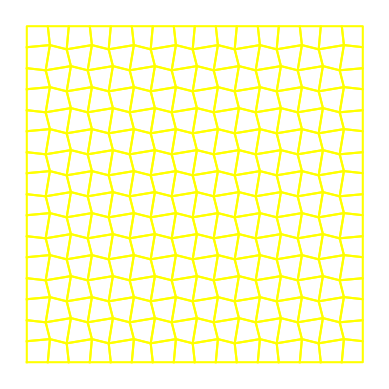

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 16
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    node_coords, p_elem2nodes, elem2nodes=shift(node_coords, p_elem2nodes, elem2nodes)

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')


    return

run_exercise_a()

I choose it also to give another form of shifting by taking random values of epsilon (between -1/3n and 1/3n).

In [ ]:
import random
def shift_random(node_coords, p_elem2nodes, elem2nodes):
    n =  int(np.sqrt(p_elem2nodes.shape[0]))
    nnodes = (n+1)**2
    b1 = [n+ i*(n+1) for i in range(n+1)]
    b2 = [i for i in range(n+1)]
    b3 = [(n+1)*n+ i for i in range(n+1)]
    b4 = [ i*(n+1) for i in range(n+1)]
    b = b1+b2+b3+b4
    for i in range(nnodes) :
      if i not in b :
        x = (2*random.random()-1)/3/n
        for j in range(2):
          node_coords[i][j]+= x
    return node_coords, p_elem2nodes, elem2nodes

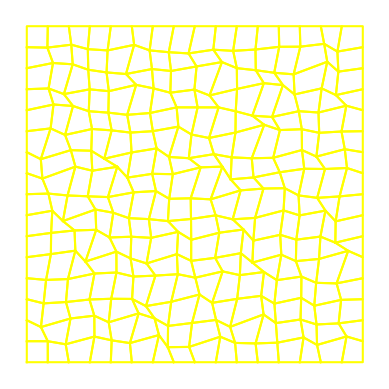

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 16
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    node_coords, p_elem2nodes, elem2nodes=shift_random(node_coords, p_elem2nodes, elem2nodes)

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')


    return

run_exercise_a()

# Question 4 :

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 200
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)


    node_coords, p_elem2nodes, elem2nodes=shift_random(node_coords, p_elem2nodes, elem2nodes)

    aspect_ratio=[compute_aspect_ratio_of_element(node_coords, p_elem2nodes, elem2nodes,elem) for elem in range(n*n)]
    edge_length= [compute_edge_length_factor_of_element(node_coords, p_elem2nodes, elem2nodes,elem) for elem in range(n*n)]

    return  aspect_ratio, edge_length


aspect_ratio, edge_length = run_exercise_a()

Text(0.5, 1.0, 'Aspect ratio')

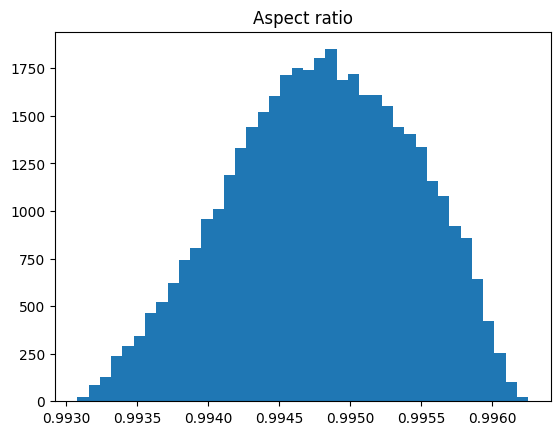

In [ ]:
plt.hist(aspect_ratio,40)
plt.title('Aspect ratio')

Text(0.5, 1.0, 'Edge Length Factor')

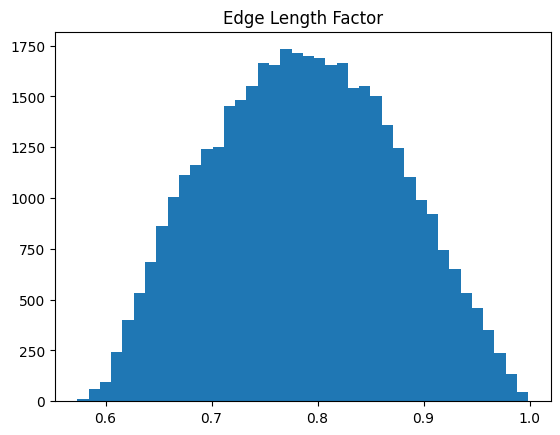

In [ ]:
plt.hist(edge_length,40)
plt.title('Edge Length Factor')

# Question 5 :

In [ ]:
def compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes):

  spacedim = node_coords.shape[1]
  nelems = p_elem2nodes.shape[0]-1
  elem_coords = np.zeros((nelems,spacedim))
  for i in range(nelems):
    nodes = elem2nodes[p_elem2nodes[i]: p_elem2nodes[i+1]]
    elem_coords[i,:] = np.average(node_coords[nodes,:],axis=0)
  return elem_coords

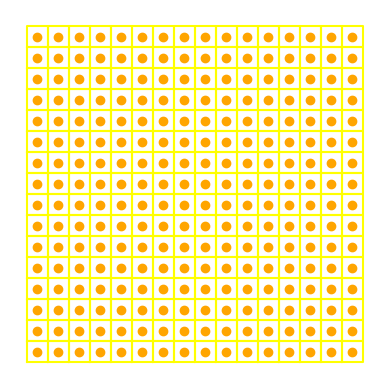

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 16
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)
    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    l_bary =compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes)

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')
    for i in range(len(l_bary)) :
          solutions._plot_node(p_elem2nodes, elem2nodes, l_bary, i, color='orange')

    return

run_exercise_a()

# Questions 6+7 :

In [ ]:

def add_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid_coords):
    node_coords = np.vstack([node_coords, nodeid_coords])
    return node_coords, p_elem2nodes, elem2nodes

def add_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elemid2nodes):

    elem2nodes = np.append(elem2nodes, elemid2nodes)
    p = elemid2nodes.shape[0]
    x= p_elem2nodes[-1]
    addd = np.array([x+p])
    p_elem2nodes = np.append(p_elem2nodes, addd)
    return node_coords, p_elem2nodes, elem2nodes

def remove_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid):
    e2n_coef = numpy.ones(len(elem2nodes), dtype=numpy.int64)
    e2n_mtx = scipy.sparse.csr_matrix((e2n_coef, elem2nodes, p_elem2nodes)) # (x,y) x : element, y : node
        # node2elems connectivity matrix
    e2n_mtx = e2n_mtx.tocsr()
    # Find rows where the value in the 5th column is 1
    rows_to_keep = np.where(e2n_mtx[:, nodeid].A.ravel() == 0)[0]
    # Remove the specified rows
    e2n_mtx = e2n_mtx[rows_to_keep]
    p_elem2nodes = e2n_mtx.indptr
    elem2nodes = e2n_mtx.indices
    return node_coords, p_elem2nodes, elem2nodes


def remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elemid):
    e2n_coef = numpy.ones(len(elem2nodes), dtype=numpy.int64)
    e2n_mtx = scipy.sparse.csr_matrix((e2n_coef, elem2nodes, p_elem2nodes)) # (x,y) x : element, y : node
        # node2elems connectivity matrix
    e2n_mtx = e2n_mtx.tocsr()
    e2n_mtx = e2n_mtx[np.arange(e2n_mtx.shape[0]) != elemid]

    p_elem2nodes = e2n_mtx.indptr
    elem2nodes = e2n_mtx.indices
    return node_coords, p_elem2nodes, elem2nodes



def quad_to_triang(node_coords, p_elem2nodes, elem2nodes):
    nelems = p_elem2nodes.shape[0]-1
    for i in range(nelems):
      nodes = elem2nodes[p_elem2nodes[i]:p_elem2nodes[i+1]]
      triangle2 = np.array([nodes[0],nodes[2],nodes[3],nodes[0]])
      triangle1 = np.array([nodes[0],nodes[1],nodes[2],nodes[0]])
      node_coords, p_elem2nodes, elem2nodes= add_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, triangle1)
      node_coords, p_elem2nodes, elem2nodes= add_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, triangle2)
    for i in range(nelems):
      node_coords, p_elem2nodes, elem2nodes= remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes,0)

    return node_coords, p_elem2nodes, elem2nodes

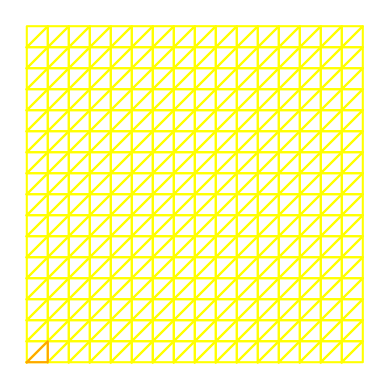

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 16
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    node_coords, p_elem2nodes, elem2nodes = quad_to_triang(node_coords, p_elem2nodes, elem2nodes)

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')
    solutions._plot_elem(p_elem2nodes, elem2nodes, node_coords, 0, color='orange')


    return



run_exercise_a()


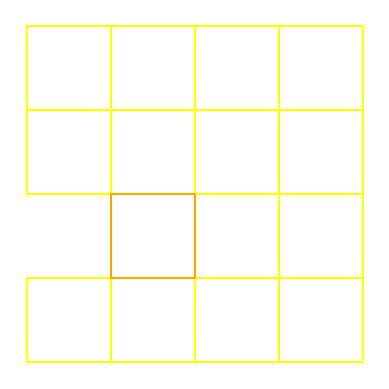

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 4
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    node_coords, p_elem2nodes, elem2nodes = remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes,4)

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')
    solutions._plot_elem(p_elem2nodes, elem2nodes, node_coords, 4, color='orange')


    return



run_exercise_a()


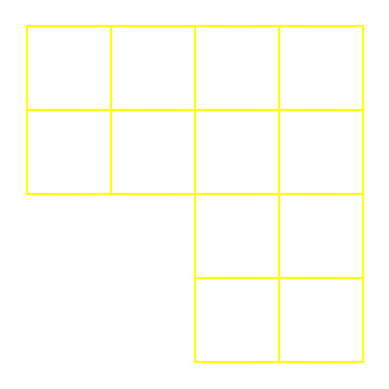

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 4
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    node_coords, p_elem2nodes, elem2nodes = remove_node_to_mesh(node_coords, p_elem2nodes, elem2nodes,6)

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')


    return


run_exercise_a()


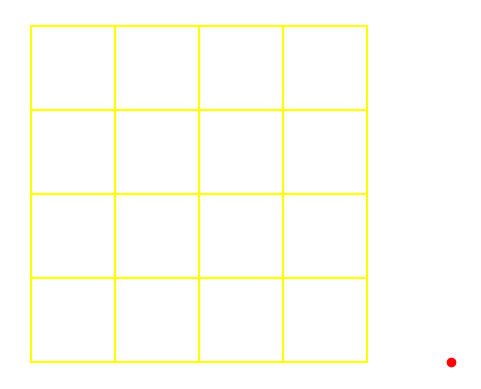

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 4
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    node_coords, p_elem2nodes, elem2nodes = add_node_to_mesh(node_coords, p_elem2nodes, elem2nodes,np.array([1/n+1,0,0]))

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')

    solutions._plot_node(p_elem2nodes, elem2nodes, node_coords,(n+1)*(n+1), color='red')

    return


run_exercise_a()


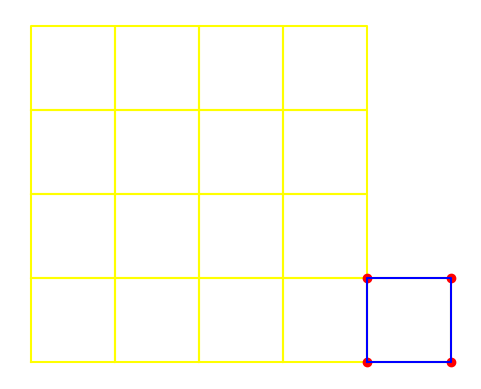

In [ ]:
def run_exercise_a():
    """Generate grid with quadrangles.
    """
    # -- generate grid with quadrangles
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n = 4
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    node_coords, p_elem2nodes, elem2nodes = add_node_to_mesh(node_coords, p_elem2nodes, elem2nodes,np.array([1/n+1,0,0]))
    node_coords, p_elem2nodes, elem2nodes = add_node_to_mesh(node_coords, p_elem2nodes, elem2nodes,np.array([1/n+1,1/n,0]))
    elem = [n,(n+1)**2,(n+1)**2+1,2*n+1]
    node_coords, p_elem2nodes, elem2nodes = add_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes,np.array(elem))

    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')

    for i in elem :
          solutions._plot_node(p_elem2nodes, elem2nodes, node_coords,i, color='red')

    solutions._plot_elem(p_elem2nodes, elem2nodes, node_coords,n*n, color='blue')


    return


run_exercise_a()


# Questions 8 :

End.


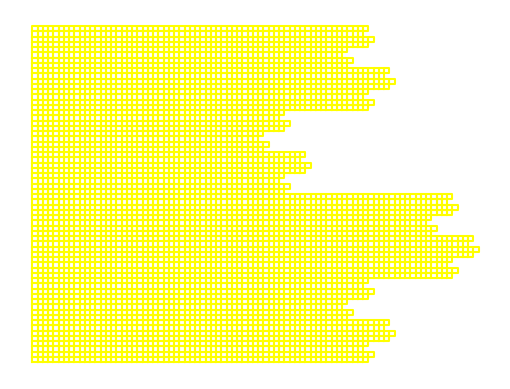

In [ ]:
import matplotlib.pyplot
import matplotlib.pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy
import os
import scipy.io
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import sys

import numpy as np
# MRG packages
import solutions


def add_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid_coords):
    node_coords = np.vstack([node_coords, nodeid_coords])
    return node_coords, p_elem2nodes, elem2nodes

def add_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elemid2nodes):

    elem2nodes = np.append(elem2nodes, elemid2nodes)
    p = elemid2nodes.shape[0]
    x= p_elem2nodes[-1]
    addd = np.array([x+p])
    p_elem2nodes = np.append(p_elem2nodes, addd)
    return node_coords, p_elem2nodes, elem2nodes

def remove_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid):
    e2n_coef = numpy.ones(len(elem2nodes), dtype=numpy.int64)
    e2n_mtx = scipy.sparse.csr_matrix((e2n_coef, elem2nodes, p_elem2nodes)) # (x,y) x : element, y : node
        # node2elems connectivity matrix
    e2n_mtx = e2n_mtx.tocsr()
# Find rows where the value in the 5th column is 1
    rows_to_keep = np.where(e2n_mtx[:, nodeid].A.ravel() == 0)[0]
# Remove the specified rows
    e2n_mtx = e2n_mtx[rows_to_keep]
    p_elem2nodes = e2n_mtx.indptr
    elem2nodes = e2n_mtx.indices
    return node_coords, p_elem2nodes, elem2nodes


def remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elemid):
    e2n_coef = numpy.ones(len(elem2nodes), dtype=numpy.int64)
    e2n_mtx = scipy.sparse.csr_matrix((e2n_coef, elem2nodes, p_elem2nodes))
    e2n_mtx = e2n_mtx.tocsr()
    e2n_mtx = e2n_mtx[np.arange(e2n_mtx.shape[0]) != elemid]

    p_elem2nodes = e2n_mtx.indptr
    elem2nodes = e2n_mtx.indices
    return node_coords, p_elem2nodes, elem2nodes

def compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes):

  spacedim = node_coords.shape[1]
  nelems = p_elem2nodes.shape[0]-1
  elem_coords = np.zeros((nelems,spacedim))
  for i in range(nelems):
    nodes = elem2nodes[p_elem2nodes[i]: p_elem2nodes[i+1]]
    elem_coords[i,:] = np.average(node_coords[nodes,:],axis=0)
  return elem_coords

def fract_add(node_coords, p_elem2nodes, elem2nodes,elem,m,n) :
    nodes = elem2nodes[p_elem2nodes[elem]:p_elem2nodes[elem+1]]
    x= node_coords[nodes[1]][0]
    y= node_coords[nodes[1]][1]
    for i in range(m) :
      p = len(node_coords)
      nodeid_coords = np.array([[x+i/n,y,0],[x+(i+1)/n,y,0],[x+(i+1)/n,y+1/n,0],[x+i/n,y+1/n,0]])
      node_coords, p_elem2nodes, elem2nodes = add_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid_coords)
      p1 = len(node_coords)
      elimd2nodes = np.arange(p,p1)
      node_coords, p_elem2nodes, elem2nodes= add_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elimd2nodes)
    return node_coords, p_elem2nodes, elem2nodes

def fract(node_coords, p_elem2nodes, elem2nodes,n,lf0,level) :
    lf = [ lf0[i*(n//(4**level)):(i+1)*(n//(4**level))] for i in range(4**level)]
    n1=len(lf[0])
    lf.sort(key=lambda x: x[-1])
    for k in range(len(lf)-1,-1,-1) :
      for i in range(n1//4*3-1,n1//4*2-1,-1) :
        for j in range(n1//4) :
          node_coords, p_elem2nodes, elem2nodes= remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes,lf[k][i]-j)
        lf[k][i]-= n1//4 * (i-n1//2+1)+(n1//4) *(n1//4)*k
      for i in range(n1//4,(n1//4)*2):
        node_coords, p_elem2nodes, elem2nodes= fract_add(node_coords, p_elem2nodes, elem2nodes,lf[k][i], n1//4,n)
        lf[k][i] = n*n -1- (n1//4*2-i-1)*n1//4 -n1//4*(n1//4)*k
      for i in range(n1//4*3,n1):
        lf[k][i] -= (k+1)*(n1//4)*(n1//4)
      for i in range(n1//4):
        lf[k][i]-= (n1//4)*(n1//4)*k
    l=[]
    for i in range(len(lf)):
      for j in range(len(lf[i])):
        l.append(lf[i][j])

    return node_coords, p_elem2nodes, elem2nodes,l


def run_exercise_a():
    """Generate grid with quadrangles.
    """
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    n =64
    nelemsx, nelemsy = n,n
    nelems = nelemsx * nelemsy
    nnodes = (nelemsx + 1) * (nelemsy + 1)

    node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

    # -- plot mesh
    fig = matplotlib.pyplot.figure(1)
    ax = matplotlib.pyplot.subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    lf0 = [n-1+ i*n for i in range(n)]
    node_coords, p_elem2nodes, elem2nodes,lf0= fract(node_coords, p_elem2nodes, elem2nodes, n,lf0,0)
    node_coords, p_elem2nodes, elem2nodes,lf0= fract(node_coords, p_elem2nodes, elem2nodes, n,lf0,1)
    node_coords, p_elem2nodes, elem2nodes,lf0= fract(node_coords, p_elem2nodes, elem2nodes, n,lf0,2)




    solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='yellow')

    #Plot Boundary

    #for i in range(len(lf0)):
       # solutions._plot_elem(p_elem2nodes, elem2nodes, node_coords, lf0[i], color='orange')

    return



if __name__ == '__main__':
    run_exercise_a()
    print('End.')


I construct the boundary in an iterative manner. Creating a function to determine the elements of the boundary would result in high complexity (the naive version is O(n**2)). Instead, I propose determining the boundary while modifying it. `lf0` gives the `element_id` of the n elements that exist in the west boundary. `lf0` is updated while modifying the boundary. Using this method, we do not add complexity.